# 03__TF_expr

In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import sys

from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## functions

In [4]:
def is_sig(row):
    if row.padj < 0.01 and np.abs(row.log2FoldChange) >= 1:
        return "sig"
    else:
        return "not sig"

## variables

In [5]:
hESC_expr_f = "../../../data/03__rna_seq/03__diff_expr/hESC.tpm.txt"
mESC_expr_f = "../../../data/03__rna_seq/03__diff_expr/mESC.tpm.txt"
orth_expr_f = "../../../data/03__rna_seq/03__diff_expr/orth.tpm.txt"
orth_de_f = "../../../data/03__rna_seq/03__diff_expr/orth.DESeq2.txt"

In [6]:
orth_f = "../../../misc/01__ensembl_orthologs/ensembl96_human_mouse_orths.txt.gz"
human_gene_map_f = "../../../misc/01__ensembl_orthologs/gencode.v25lift37.GENE_ID_TO_NAME_AND_BIOTYPE_MAP.txt"
mouse_gene_map_f = "../../../misc/01__ensembl_orthologs/gencode.vM13.GENE_ID_TO_NAME_AND_BIOTYPE_MAP.txt"

In [7]:
motif_info_dir = "../../../misc/02__motif_info"
human_map_f = "%s/01__meme_files/human_cisbp_id_map.updated.txt" % motif_info_dir
mouse_map_f = "%s/01__meme_files/mouse_cisbp_id_map.updated.txt" % motif_info_dir

## 1. import data

In [8]:
hESC_expr = pd.read_table(hESC_expr_f).reset_index()
mESC_expr = pd.read_table(mESC_expr_f).reset_index()
hESC_expr.head()

,index,rep1,rep2
0,ENSG00000223972,1.779395,0.000000
1,ENSG00000227232,40.036384,40.463195
2,ENSG00000243485,2.669092,0.000000
3,ENSG00000237613,0.000000,0.000000
4,ENSG00000268020,0.000000,0.000000


In [9]:
orth_expr = pd.read_table(orth_expr_f).reset_index()
orth_expr.head()

,index,hESC_rep1,hESC_rep2,mESC_rep1,mESC_rep2,mESC_rep3
0,ENSG00000187634__ENSMUSG00000096351,83.679350,79.231477,5.435120,5.175746,8.009315
1,ENSG00000188976__ENSMUSG00000095567,6687.911089,5203.261186,14972.669086,14729.139239,15010.256691
2,ENSG00000187961__ENSMUSG00000078485,896.564459,824.243874,714.174792,777.397116,744.065336
3,ENSG00000187642__ENSMUSG00000078486,10.115086,4.730237,30.436673,22.773284,16.018629
4,ENSG00000187608__ENSMUSG00000035692,502.076097,572.358731,6.522144,5.175746,4.004657


In [10]:
orth_de = pd.read_table(orth_de_f).reset_index()
orth_de.head()

,index,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000187634__ENSMUSG00000096351,36.306202,3.692209,0.558543,6.610430,3.832054e-11,7.549767e-11
1,ENSG00000188976__ENSMUSG00000095567,11320.647458,-1.325181,0.103735,-12.774677,2.270873e-37,8.353734e-37
2,ENSG00000187961__ENSMUSG00000078485,791.289116,0.208486,0.112457,1.853912,6.375168e-02,7.966884e-02
3,ENSG00000187642__ENSMUSG00000078486,16.814782,-1.606687,0.778087,-2.064918,3.893073e-02,4.967260e-02
4,ENSG00000187608__ENSMUSG00000035692,218.027475,6.712128,0.420436,15.964673,2.252187e-57,1.128198e-56


In [11]:
orth = pd.read_table(orth_f)
orth.head()

,Gene stable ID,Transcript stable ID,Gene name,Mouse gene stable ID,Mouse protein or transcript stable ID,Mouse gene name,%id. target Mouse gene identical to query gene,%id. query gene identical to target Mouse gene,"Mouse orthology confidence [0 low, 1 high]",Mouse homology type
0,ENSG00000198888,ENST00000361390,MT-ND1,ENSMUSG00000064341,ENSMUSP00000080991,mt-Nd1,77.0440,77.0440,1.0,ortholog_one2one
1,ENSG00000198763,ENST00000361453,MT-ND2,ENSMUSG00000064345,ENSMUSP00000080992,mt-Nd2,57.0605,57.3913,1.0,ortholog_one2one
2,ENSG00000198804,ENST00000361624,MT-CO1,ENSMUSG00000064351,ENSMUSP00000080993,mt-Co1,90.8382,90.6615,1.0,ortholog_one2one
3,ENSG00000198712,ENST00000361739,MT-CO2,ENSMUSG00000064354,ENSMUSP00000080994,mt-Co2,71.3656,71.3656,1.0,ortholog_one2one
4,ENSG00000228253,ENST00000361851,MT-ATP8,ENSMUSG00000064356,ENSMUSP00000080995,mt-Atp8,45.5882,46.2687,0.0,ortholog_one2one


In [12]:
human_gene_map = pd.read_table(human_gene_map_f, header=None)
human_gene_map.columns = ["gene_id", "biotype", "gene_name"]
human_gene_map.head()

,gene_id,biotype,gene_name
0,ENSG00000223972.5_1,transcribed_unprocessed_pseudogene,DDX11L1
1,ENSG00000227232.5_1,unprocessed_pseudogene,WASH7P
2,ENSG00000243485.4_2,lincRNA,MIR1302-2
3,ENSG00000237613.2_1,lincRNA,FAM138A
4,ENSG00000268020.3_1,unprocessed_pseudogene,OR4G4P


In [13]:
mouse_gene_map = pd.read_table(mouse_gene_map_f, header=None)
mouse_gene_map.columns = ["gene_id", "biotype", "gene_name"]
mouse_gene_map.head()

,gene_id,biotype,gene_name
0,ENSMUSG00000102693.1,TEC,4933401J01Rik
1,ENSMUSG00000064842.1,snRNA,Gm26206
2,ENSMUSG00000051951.5,protein_coding,Xkr4
3,ENSMUSG00000102851.1,processed_pseudogene,Gm18956
4,ENSMUSG00000103377.1,TEC,Gm37180


In [14]:
human_map = pd.read_table(human_map_f, header=None)
human_map.columns = ["motif_id", "gene_name"]
human_map.head()

,motif_id,gene_name
0,M0082_1.02,TFAP2B
1,M0083_1.02,TFAP2B
2,M0084_1.02,TFAP2B
3,M0085_1.02,TFAP2B
4,M0100_1.02,ARID3A


In [15]:
mouse_map = pd.read_table(mouse_map_f, header=None)
mouse_map.columns = ["motif_id", "gene_name"]
mouse_map.head()

,motif_id,gene_name
0,M0082_1.02,TFAP2A
1,M0083_1.02,TFAP2A
2,M0084_1.02,TFAP2A
3,M0085_1.02,TFAP2A
4,M0100_1.02,ARID3B


## 2. do some QC on RNA-seq

In [16]:
human_gene_map["index"] = human_gene_map["gene_id"].str.split(".", expand=True)[0]
mouse_gene_map["index"] = mouse_gene_map["gene_id"].str.split(".", expand=True)[0]
mouse_gene_map.head()

,gene_id,biotype,gene_name,index
0,ENSMUSG00000102693.1,TEC,4933401J01Rik,ENSMUSG00000102693
1,ENSMUSG00000064842.1,snRNA,Gm26206,ENSMUSG00000064842
2,ENSMUSG00000051951.5,protein_coding,Xkr4,ENSMUSG00000051951
3,ENSMUSG00000102851.1,processed_pseudogene,Gm18956,ENSMUSG00000102851
4,ENSMUSG00000103377.1,TEC,Gm37180,ENSMUSG00000103377


In [17]:
hESC_expr = hESC_expr.merge(human_gene_map, on="index", how="left")
hESC_expr.sample(5)

,index,rep1,rep2,gene_id,biotype,gene_name
21266,ENSG00000205186,0.000000,0.000000,ENSG00000205186.2_1,protein_coding,FABP9
41539,ENSG00000263393,13.345461,7.867843,ENSG00000263393.1_1,antisense,RP11-53I6.4
26802,ENSG00000175220,3298.108308,2636.851549,ENSG00000175220.11_2,protein_coding,ARHGAP1
6469,ENSG00000233729,1.779395,5.619888,ENSG00000233729.1_1,antisense,AC016909.1
28811,ENSG00000177406,82.741859,127.009474,ENSG00000177406.4_1,antisense,RP11-218M22.1


In [18]:
mESC_expr = mESC_expr.merge(mouse_gene_map, on="index", how="left")
mESC_expr.sample(5)

,index,rep1,rep2,rep3,gene_id,biotype,gene_name
47873,ENSMUSG00000015665,0.000000,0.000000,0.000000,ENSMUSG00000015665.8,protein_coding,Awat1
15110,ENSMUSG00000054675,8.998718,4.281684,0.827301,ENSMUSG00000054675.5,protein_coding,Tmem119
4765,ENSMUSG00000049044,47.243272,57.802735,71.975186,ENSMUSG00000049044.16,protein_coding,Rapgef4
11958,ENSMUSG00000054958,2.249680,2.140842,1.654602,ENSMUSG00000054958.6,protein_coding,Nt5c1a
13921,ENSMUSG00000106292,0.000000,0.000000,0.000000,ENSMUSG00000106292.1,TEC,Gm43174


In [19]:
human_genes_to_check = ["XIST", "SRY", "RPS4Y1", "DDX3Y", "POU5F1", "NANOG", "SOX2", "EOMES", "SOX17", "FOXA2"]

In [20]:
human_sub = hESC_expr[hESC_expr["gene_name"].isin(human_genes_to_check)]
human_sub = pd.melt(human_sub[["gene_name", "rep1", "rep2"]], id_vars="gene_name")
human_sub.head()

,gene_name,variable,value
0,EOMES,rep1,2110.362262
1,SOX2,rep1,15816.150901
2,POU5F1,rep1,48615.735710
3,SOX17,rep1,505.348130
4,NANOG,rep1,5629.115529


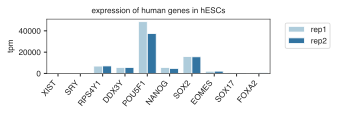

In [21]:
fig = plt.figure(figsize=(4, 1))

ax = sns.barplot(data=human_sub, x="gene_name", y="value", hue="variable", palette="Paired", 
                 order=human_genes_to_check)
#ax.set_yscale('symlog')
ax.set_xticklabels(human_genes_to_check, va="top", ha="right", rotation=50)
ax.set_ylabel("tpm")
ax.set_title("expression of human genes in hESCs")
ax.set_xlabel("")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

In [22]:
mouse_genes_to_check = ["Xist", "Sry", "Eif2s3y", "Ddx3y", "Pou5f1", "Nanog", "Sox2", "Eomes", "Sox17", "Foxa2"]

In [23]:
mouse_sub = mESC_expr[mESC_expr["gene_name"].isin(mouse_genes_to_check)]
mouse_sub = pd.melt(mouse_sub[["gene_name", "rep1", "rep2", "rep3"]], id_vars="gene_name")
mouse_sub.head()

,gene_name,variable,value
0,Sox17,rep1,15.747757
1,Foxa2,rep1,11.248398
2,Sox2,rep1,26213.266644
3,Nanog,rep1,46427.762648
4,Eomes,rep1,557.920540


In [24]:
mouse_sub.gene_name.unique()

array(['Sox17', 'Foxa2', 'Sox2', 'Nanog', 'Eomes', 'Pou5f1', 'Xist',
       'Eif2s3y', 'Ddx3y', 'Sry'], dtype=object)

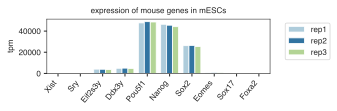

In [25]:
fig = plt.figure(figsize=(4, 1))

ax = sns.barplot(data=mouse_sub, x="gene_name", y="value", hue="variable", palette="Paired", 
                 order=mouse_genes_to_check)
#ax.set_yscale('symlog')
ax.set_xticklabels(mouse_genes_to_check, va="top", ha="right", rotation=50)
ax.set_ylabel("tpm")
ax.set_title("expression of mouse genes in mESCs")
ax.set_xlabel("")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

## 3. look at expression of TFs in hESCs

In [26]:
uniq_human_TFs = human_map["gene_name"].unique()
print(len(uniq_human_TFs))

TFs_in_seq = [x for x in uniq_human_TFs if x in list(hESC_expr["gene_name"])]
print(len(TFs_in_seq))

TFs_missing = [x for x in uniq_human_TFs if x not in list(hESC_expr["gene_name"])]
print(len(TFs_missing))

529
508
21


In [27]:
TFs_missing

['ENSG00000250542',
 'ZNF187',
 'ZFP161',
 'MLL',
 'C11orf9',
 'PRKRIR',
 'AC002126.6',
 'MYCL1',
 'DUX1',
 'ENSG00000261932',
 'CHD2',
 'MTERF',
 'NFE4_HUMAN',
 'ZNF238',
 'ENSG00000269523',
 'ZNF271',
 'ZNF834',
 'ZNF542',
 'ZNF663',
 'ENSG00000178604',
 'ZNF883']

the above 21 TFs are missing from the RNA-seq so will not be included (I hand checked a few and couldn't find easy aliases, might look more later)

In [28]:
hESC_TFs = hESC_expr[hESC_expr["gene_name"].isin(uniq_human_TFs)]
print(len(hESC_TFs))
hESC_TFs.head()

511


,index,rep1,rep2,gene_id,biotype,gene_name
146,ENSG00000197921,81.852162,121.389585,ENSG00000197921.5_1,protein_coding,HES5
206,ENSG00000069812,25.801225,34.843307,ENSG00000069812.11_1,protein_coding,HES2
253,ENSG00000074800,92890.637744,88246.856627,ENSG00000074800.13_2,protein_coding,ENO1
504,ENSG00000009709,160.145534,320.333628,ENSG00000009709.11_1,protein_coding,PAX7
616,ENSG00000007968,549.833001,614.815770,ENSG00000007968.6_1,protein_coding,E2F2


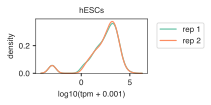

In [29]:
fig = plt.figure(figsize=(2, 1))

ax = sns.distplot(np.log10(hESC_TFs["rep1"]+0.001), label="rep 1", color=sns.color_palette("Set2")[0], hist=False)
sns.distplot(np.log10(hESC_TFs["rep2"]+0.001), label="rep 2", color=sns.color_palette("Set2")[1], hist=False)

ax.set_xlabel("log10(tpm + 0.001)")
ax.set_ylabel("density")
ax.set_title("hESCs")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

In [30]:
hESC_TFs["mean_tpm"] = hESC_TFs[["rep1", "rep2"]].mean(axis=1)
hESC_TFs.head()

,index,rep1,rep2,gene_id,biotype,gene_name,mean_tpm
146,ENSG00000197921,81.852162,121.389585,ENSG00000197921.5_1,protein_coding,HES5,101.620874
206,ENSG00000069812,25.801225,34.843307,ENSG00000069812.11_1,protein_coding,HES2,30.322266
253,ENSG00000074800,92890.637744,88246.856627,ENSG00000074800.13_2,protein_coding,ENO1,90568.747186
504,ENSG00000009709,160.145534,320.333628,ENSG00000009709.11_1,protein_coding,PAX7,240.239581
616,ENSG00000007968,549.833001,614.815770,ENSG00000007968.6_1,protein_coding,E2F2,582.324386


In [31]:
hESC_TFs_expr = list(hESC_TFs[hESC_TFs["mean_tpm"] > 1]["gene_name"])
len(hESC_TFs_expr)

485

## 4. look at expression of orthologous TFs in mouse

In [32]:
human_mouse_TFs = hESC_TFs[["index", "gene_name", "mean_tpm"]]
print(len(human_mouse_TFs))
human_mouse_TFs = human_mouse_TFs.merge(orth[["Gene stable ID", 
                                              "Mouse gene stable ID", 
                                              "Gene name",
                                              "Mouse gene name"]].drop_duplicates(),
                                        left_on=["index", "gene_name"],
                                        right_on=["Gene stable ID", "Gene name"])
human_mouse_TFs.drop(["Gene stable ID", "Gene name"], axis=1, inplace=True)
human_mouse_TFs.columns = ["gene_id_human", "gene_name_human", "mean_tpm_human", "gene_id_mouse", "gene_name_mouse"]
print(len(human_mouse_TFs))
human_mouse_TFs.head()

511
494


,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse
0,ENSG00000197921,HES5,101.620874,ENSMUSG00000048001,Hes5
1,ENSG00000069812,HES2,30.322266,ENSMUSG00000028940,Hes2
2,ENSG00000074800,ENO1,90568.747186,ENSMUSG00000059040,Eno1b
3,ENSG00000074800,ENO1,90568.747186,ENSMUSG00000063524,Eno1
4,ENSG00000009709,PAX7,240.239581,ENSMUSG00000028736,Pax7


In [33]:
mESC_expr["mean_tpm_mouse"] = mESC_expr[["rep1", "rep2", "rep3"]].mean(axis=1)
mESC_expr.head()

,index,rep1,rep2,rep3,gene_id,biotype,gene_name,mean_tpm_mouse
0,ENSMUSG00000102693,0.00000,0.000000,0.000000,ENSMUSG00000102693.1,TEC,4933401J01Rik,0.000000
1,ENSMUSG00000064842,0.00000,0.000000,0.000000,ENSMUSG00000064842.1,snRNA,Gm26206,0.000000
2,ENSMUSG00000051951,2.24968,2.140842,1.654602,ENSMUSG00000051951.5,protein_coding,Xkr4,2.015041
3,ENSMUSG00000102851,0.00000,0.000000,0.000000,ENSMUSG00000102851.1,processed_pseudogene,Gm18956,0.000000
4,ENSMUSG00000103377,0.00000,0.000000,0.000000,ENSMUSG00000103377.1,TEC,Gm37180,0.000000


In [34]:
human_mouse_TFs = human_mouse_TFs.merge(mESC_expr[["index", "gene_name", "mean_tpm_mouse"]],
                                        left_on=["gene_id_mouse", "gene_name_mouse"],
                                        right_on=["index", "gene_name"])
human_mouse_TFs.drop(["index", "gene_name"], axis=1, inplace=True)
print(len(human_mouse_TFs))
human_mouse_TFs.head()

485


,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse
0,ENSG00000197921,HES5,101.620874,ENSMUSG00000048001,Hes5,0.000000
1,ENSG00000069812,HES2,30.322266,ENSMUSG00000028940,Hes2,11.737072
2,ENSG00000074800,ENO1,90568.747186,ENSMUSG00000059040,Eno1b,1312.160341
3,ENSG00000074800,ENO1,90568.747186,ENSMUSG00000063524,Eno1,73990.521463
4,ENSG00000009709,PAX7,240.239581,ENSMUSG00000028736,Pax7,8.372211


In [35]:
mESC_TFs_expr = list(human_mouse_TFs[human_mouse_TFs["mean_tpm_mouse"] > 1]["gene_name_mouse"])
len(mESC_TFs_expr)

448

## 5. look at orthologous expression

In [36]:
orth_expr["gene_id_human"] = orth_expr["index"].str.split("__", expand=True)[0]
orth_expr["gene_id_mouse"] = orth_expr["index"].str.split("__", expand=True)[1]
orth_expr.head()

,index,hESC_rep1,hESC_rep2,mESC_rep1,mESC_rep2,mESC_rep3,gene_id_human,gene_id_mouse
0,ENSG00000187634__ENSMUSG00000096351,83.679350,79.231477,5.435120,5.175746,8.009315,ENSG00000187634,ENSMUSG00000096351
1,ENSG00000188976__ENSMUSG00000095567,6687.911089,5203.261186,14972.669086,14729.139239,15010.256691,ENSG00000188976,ENSMUSG00000095567
2,ENSG00000187961__ENSMUSG00000078485,896.564459,824.243874,714.174792,777.397116,744.065336,ENSG00000187961,ENSMUSG00000078485
3,ENSG00000187642__ENSMUSG00000078486,10.115086,4.730237,30.436673,22.773284,16.018629,ENSG00000187642,ENSMUSG00000078486
4,ENSG00000187608__ENSMUSG00000035692,502.076097,572.358731,6.522144,5.175746,4.004657,ENSG00000187608,ENSMUSG00000035692


In [37]:
orth_sub = orth[["Gene stable ID", "Mouse gene stable ID", "Gene name", "Mouse gene name"]].drop_duplicates()
orth_sub.columns = ["gene_id_human", "gene_id_mouse", "gene_name_human", "gene_name_mouse"]
orth_expr = orth_expr.merge(orth_sub, on=["gene_id_human", "gene_id_mouse"]).drop_duplicates()
orth_expr.head()

,index,hESC_rep1,hESC_rep2,mESC_rep1,mESC_rep2,mESC_rep3,gene_id_human,gene_id_mouse,gene_name_human,gene_name_mouse
0,ENSG00000187634__ENSMUSG00000096351,83.679350,79.231477,5.435120,5.175746,8.009315,ENSG00000187634,ENSMUSG00000096351,SAMD11,Samd11
1,ENSG00000188976__ENSMUSG00000095567,6687.911089,5203.261186,14972.669086,14729.139239,15010.256691,ENSG00000188976,ENSMUSG00000095567,NOC2L,Noc2l
2,ENSG00000187961__ENSMUSG00000078485,896.564459,824.243874,714.174792,777.397116,744.065336,ENSG00000187961,ENSMUSG00000078485,KLHL17,Plekhn1
3,ENSG00000187642__ENSMUSG00000078486,10.115086,4.730237,30.436673,22.773284,16.018629,ENSG00000187642,ENSMUSG00000078486,PERM1,Perm1
4,ENSG00000187608__ENSMUSG00000035692,502.076097,572.358731,6.522144,5.175746,4.004657,ENSG00000187608,ENSMUSG00000035692,ISG15,Isg15


In [38]:
orth_expr["mean_tpm_hESC"] = orth_expr[["hESC_rep1", "hESC_rep2"]].mean(axis=1)
orth_expr["mean_tpm_mESC"] = orth_expr[["mESC_rep1", "mESC_rep2", "mESC_rep3"]].mean(axis=1)
orth_expr.head()

,index,hESC_rep1,hESC_rep2,mESC_rep1,mESC_rep2,mESC_rep3,gene_id_human,gene_id_mouse,gene_name_human,gene_name_mouse,mean_tpm_hESC,mean_tpm_mESC
0,ENSG00000187634__ENSMUSG00000096351,83.679350,79.231477,5.435120,5.175746,8.009315,ENSG00000187634,ENSMUSG00000096351,SAMD11,Samd11,81.455413,6.206727
1,ENSG00000188976__ENSMUSG00000095567,6687.911089,5203.261186,14972.669086,14729.139239,15010.256691,ENSG00000188976,ENSMUSG00000095567,NOC2L,Noc2l,5945.586138,14904.021672
2,ENSG00000187961__ENSMUSG00000078485,896.564459,824.243874,714.174792,777.397116,744.065336,ENSG00000187961,ENSMUSG00000078485,KLHL17,Plekhn1,860.404167,745.212415
3,ENSG00000187642__ENSMUSG00000078486,10.115086,4.730237,30.436673,22.773284,16.018629,ENSG00000187642,ENSMUSG00000078486,PERM1,Perm1,7.422662,23.076196
4,ENSG00000187608__ENSMUSG00000035692,502.076097,572.358731,6.522144,5.175746,4.004657,ENSG00000187608,ENSMUSG00000035692,ISG15,Isg15,537.217414,5.234183


In [39]:
orth_expr = orth_expr.merge(orth_de, on="index")
orth_expr.head()

,index,hESC_rep1,hESC_rep2,mESC_rep1,mESC_rep2,mESC_rep3,gene_id_human,gene_id_mouse,gene_name_human,gene_name_mouse,mean_tpm_hESC,mean_tpm_mESC,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000187634__ENSMUSG00000096351,83.679350,79.231477,5.435120,5.175746,8.009315,ENSG00000187634,ENSMUSG00000096351,SAMD11,Samd11,81.455413,6.206727,36.306202,3.692209,0.558543,6.610430,3.832054e-11,7.549767e-11
1,ENSG00000188976__ENSMUSG00000095567,6687.911089,5203.261186,14972.669086,14729.139239,15010.256691,ENSG00000188976,ENSMUSG00000095567,NOC2L,Noc2l,5945.586138,14904.021672,11320.647458,-1.325181,0.103735,-12.774677,2.270873e-37,8.353734e-37
2,ENSG00000187961__ENSMUSG00000078485,896.564459,824.243874,714.174792,777.397116,744.065336,ENSG00000187961,ENSMUSG00000078485,KLHL17,Plekhn1,860.404167,745.212415,791.289116,0.208486,0.112457,1.853912,6.375168e-02,7.966884e-02
3,ENSG00000187642__ENSMUSG00000078486,10.115086,4.730237,30.436673,22.773284,16.018629,ENSG00000187642,ENSMUSG00000078486,PERM1,Perm1,7.422662,23.076196,16.814782,-1.606687,0.778087,-2.064918,3.893073e-02,4.967260e-02
4,ENSG00000187608__ENSMUSG00000035692,502.076097,572.358731,6.522144,5.175746,4.004657,ENSG00000187608,ENSMUSG00000035692,ISG15,Isg15,537.217414,5.234183,218.027475,6.712128,0.420436,15.964673,2.252187e-57,1.128198e-56


In [40]:
orth_expr["sig"] = orth_expr.apply(is_sig, axis=1)
orth_expr.sig.value_counts()

not sig    10216
sig         9642
Name: sig, dtype: int64

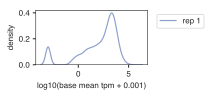

In [41]:
fig = plt.figure(figsize=(2, 1))

ax = sns.distplot(np.log10(orth_expr["baseMean"]+0.001), label="rep 1", color=sns.color_palette("Set2")[2], hist=False)

ax.set_xlabel("log10(base mean tpm + 0.001)")
ax.set_ylabel("density")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

In [42]:
orth_expr_filt = orth_expr[orth_expr["baseMean"] >= 1]
len(orth_expr_filt)

17346

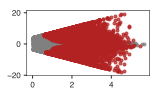

In [43]:
fig, ax = plt.subplots(figsize=(2.2, 1.2), nrows=1, ncols=1)

ax.scatter(np.log10(orth_expr_filt[orth_expr_filt["sig"] == "not sig"]["baseMean"]+0.001), 
           orth_expr_filt[orth_expr_filt["sig"] == "not sig"]["log2FoldChange"],
           color="gray", alpha=0.75, s=10, rasterized=True)
ax.scatter(np.log10(orth_expr_filt[orth_expr_filt["sig"] == "sig"]["baseMean"]+0.001), 
           orth_expr_filt[orth_expr_filt["sig"] == "sig"]["log2FoldChange"],
           color="firebrick", alpha=0.75, s=10, rasterized=True)

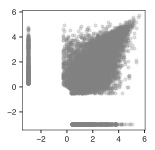

In [44]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

ax.scatter(np.log10(orth_expr_filt["mean_tpm_hESC"]+0.001), 
           np.log10(orth_expr_filt["mean_tpm_mESC"]+0.001),
           color="gray", alpha=0.25, s=10, rasterized=True)

In [45]:
orth_tf_expr = human_mouse_TFs.merge(orth_expr, on=["gene_id_human", "gene_name_human", 
                                                    "gene_id_mouse", "gene_name_mouse"]).drop_duplicates()
print(len(orth_tf_expr))
orth_tf_expr.head()

480


,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,index,hESC_rep1,hESC_rep2,mESC_rep1,...,mESC_rep3,mean_tpm_hESC,mean_tpm_mESC,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,sig
0,ENSG00000197921,HES5,101.620874,ENSMUSG00000048001,Hes5,0.000000,ENSG00000197921__ENSMUSG00000048001,84.598903,127.716411,0.000000,...,0.000000,106.157657,0.000000,42.463063,9.220488,1.288307,7.157056,8.242812e-13,1.707594e-12,sig
1,ENSG00000069812,HES2,30.322266,ENSMUSG00000028940,Hes2,11.737072,ENSG00000069812__ENSMUSG00000028940,26.667045,36.659340,15.218337,...,6.407452,31.663193,11.349193,19.474793,1.493640,0.690207,2.164048,3.046069e-02,3.923633e-02,not sig
2,ENSG00000074800,ENO1,90568.747186,ENSMUSG00000059040,Eno1b,1312.160341,ENSG00000074800__ENSMUSG00000059040,96007.800503,92846.283076,1046.804148,...,1507.353028,94427.041789,1269.240988,38532.361309,6.215109,0.127308,48.819290,0.000000e+00,0.000000e+00,sig
3,ENSG00000074800,ENO1,90568.747186,ENSMUSG00000063524,Eno1,73990.521463,ENSG00000074800__ENSMUSG00000063524,96007.800503,92846.283076,69674.979703,...,74470.608138,94427.041789,71564.015687,80709.226128,0.399941,0.052829,7.570534,3.716932e-14,8.007727e-14,not sig
4,ENSG00000009709,PAX7,240.239581,ENSMUSG00000028736,Pax7,8.372211,ENSG00000009709__ENSMUSG00000028736,165.519592,337.029418,10.870240,...,7.208383,251.274505,8.096506,105.367706,4.965287,0.503225,9.866923,5.791398e-23,1.561741e-22,sig


In [46]:
orth_tf_expr = orth_tf_expr[["gene_id_human", "gene_name_human", "mean_tpm_human", "gene_id_mouse", "gene_name_mouse",
                             "mean_tpm_mouse", "baseMean", "log2FoldChange", "lfcSE", "padj", "sig"]].drop_duplicates()
len(orth_tf_expr)

480

In [47]:
# remove any orth pair that maps to more than one gene
tmp = orth_tf_expr.groupby("gene_name_human")["gene_name_mouse"].agg("count").reset_index()
human_dupe_orths = tmp[tmp["gene_name_mouse"] > 1]
print(len(human_dupe_orths))
human_dupe_orths.head()

5


,gene_name_human,gene_name_mouse
89,ENO1,2
134,GTF3C2,2
445,ZKSCAN4,2
453,ZNF274,2
465,ZNF524,2


In [48]:
# remove any orth pair that maps to more than one gene
tmp = orth_tf_expr.groupby("gene_name_mouse")["gene_name_human"].agg("count").reset_index()
mouse_dupe_orths = tmp[tmp["gene_name_human"] > 1]
print(len(mouse_dupe_orths))
mouse_dupe_orths.head()

0


,gene_name_mouse,gene_name_human


In [49]:
orth_tf_expr = orth_tf_expr[~orth_tf_expr["gene_name_human"].isin(human_dupe_orths["gene_name_human"])]
len(orth_tf_expr)

470

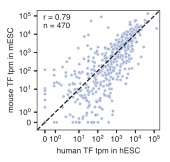

In [50]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

ax.scatter(orth_tf_expr["mean_tpm_human"], 
           orth_tf_expr["mean_tpm_mouse"],
           color=sns.color_palette("Set2")[2], alpha=0.75, s=10, 
           linewidths=0.5, edgecolors="white")
ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.plot([-0.75, 200000], [-0.75, 200000], "k", linestyle="dashed")
ax.set_xlim((-0.75, 200000))
ax.set_ylim((-0.75, 200000))

ax.set_xlabel("human TF tpm in hESC")
ax.set_ylabel("mouse TF tpm in mESC")

# annotate corr
no_nan = orth_tf_expr[(~pd.isnull(orth_tf_expr["mean_tpm_human"])) & 
                      (~pd.isnull(orth_tf_expr["mean_tpm_mouse"]))]
r, p = spearmanr(no_nan["mean_tpm_human"], no_nan["mean_tpm_mouse"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
fig.savefig("TF_human_v_mouse_scatter.pdf", dpi="figure", bbox_inches="tight")

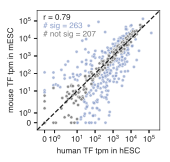

In [51]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

sig = orth_tf_expr[orth_tf_expr["sig"] == "sig"]
not_sig = orth_tf_expr[orth_tf_expr["sig"] == "not sig"]

ax.scatter(sig["mean_tpm_human"], 
           sig["mean_tpm_mouse"],
           color=sns.color_palette("Set2")[2], alpha=0.75, s=10, 
           linewidths=0.5, edgecolors="white")

ax.scatter(not_sig["mean_tpm_human"], 
           not_sig["mean_tpm_mouse"],
           color="gray", alpha=0.9, s=10, 
           linewidths=0.5, edgecolors="white")

ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.plot([-0.75, 400000], [-0.75, 400000], "k", linestyle="dashed")
ax.set_xlim((-0.75, 400000))
ax.set_ylim((-0.75, 400000))

ax.set_xlabel("human TF tpm in hESC")
ax.set_ylabel("mouse TF tpm in mESC")

# annotate corr
no_nan = orth_tf_expr[(~pd.isnull(orth_tf_expr["mean_tpm_human"])) & 
                      (~pd.isnull(orth_tf_expr["mean_tpm_mouse"]))]
r, p = spearmanr(no_nan["mean_tpm_human"], no_nan["mean_tpm_mouse"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "# sig = %s" % (len(sig)), ha="left", va="top", fontsize=fontsize, 
        color=sns.color_palette("Set2")[2],
        transform=ax.transAxes)
ax.text(0.05, 0.83, "# not sig = %s" % (len(not_sig)), ha="left", va="top", fontsize=fontsize, color="gray",
        transform=ax.transAxes)
fig.savefig("TF_human_v_mouse_scatter.w_sig_outline.pdf", dpi="figure", bbox_inches="tight")

In [52]:
sig.sort_values(by="log2FoldChange").head()

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,baseMean,log2FoldChange,lfcSE,padj,sig
326,ENSG00000119715,ESRRB,43.996854,ENSMUSG00000021255,Esrrb,53702.657586,31183.054223,-10.185911,0.165036,0.000000e+00,sig
470,ENSG00000123576,ESX1,0.000000,ENSMUSG00000023443,Esx1,115.665230,67.115254,-9.185906,1.491783,1.396911e-09,sig
58,ENSG00000115112,TFCP2L1,154.398981,ENSMUSG00000026380,Tfcp2l1,88671.367242,51521.558127,-9.059470,0.303870,4.719561e-194,sig
461,ENSG00000169297,NR0B1,19.505045,ENSMUSG00000025056,Nr0b1,7501.383613,4361.334098,-8.508988,0.438659,5.535039e-83,sig
207,ENSG00000119138,KLF9,31.773952,ENSMUSG00000033863,Klf9,9141.369142,5318.066382,-8.082153,0.190824,0.000000e+00,sig


In [53]:
sig.sort_values(by="log2FoldChange", ascending=False).head()

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,baseMean,log2FoldChange,lfcSE,padj,sig
158,ENSG00000105996,HOXA2,379.114862,ENSMUSG00000014704,Hoxa2,0.000000,158.608368,11.122159,1.242702,8.701934e-19,sig
133,ENSG00000008196,TFAP2B,606.219550,ENSMUSG00000025927,Tfap2b,0.749893,254.114368,9.912814,1.320828,1.313022e-13,sig
203,ENSG00000176399,DMRTA1,649.407368,ENSMUSG00000043753,Dmrta1,1.106700,271.654632,9.462802,0.855984,6.327054e-28,sig
0,ENSG00000197921,HES5,101.620874,ENSMUSG00000048001,Hes5,0.000000,42.463063,9.220488,1.288307,1.707594e-12,sig
88,ENSG00000109705,NKX3-2,160.718872,ENSMUSG00000049691,Nkx3-2,0.374947,67.300712,8.919670,1.238275,1.221521e-12,sig


## 6. write files

In [54]:
orth_tf_expr.head()

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,baseMean,log2FoldChange,lfcSE,padj,sig
0,ENSG00000197921,HES5,101.620874,ENSMUSG00000048001,Hes5,0.000000,42.463063,9.220488,1.288307,1.707594e-12,sig
1,ENSG00000069812,HES2,30.322266,ENSMUSG00000028940,Hes2,11.737072,19.474793,1.493640,0.690207,3.923633e-02,not sig
4,ENSG00000009709,PAX7,240.239581,ENSMUSG00000028736,Pax7,8.372211,105.367706,4.965287,0.503225,1.561741e-22,sig
5,ENSG00000007968,E2F2,582.324386,ENSMUSG00000018983,E2f2,737.478304,671.003203,-0.234384,0.123640,7.274510e-02,not sig
6,ENSG00000020633,RUNX3,32.967646,ENSMUSG00000070691,Runx3,41.452263,37.799922,-0.224945,0.457367,6.626580e-01,not sig


In [55]:
orth_tf_expr[orth_tf_expr["gene_name_human"] == "ZNF524"]

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,baseMean,log2FoldChange,lfcSE,padj,sig


In [56]:
orth_tf_expr_f = "../../../data/03__rna_seq/04__TF_expr/orth_TF_expression.txt"
orth_tf_expr.to_csv(orth_tf_expr_f, sep="\t", index=False)

In [57]:
hESC_TFs = hESC_TFs[["index", "gene_name", "mean_tpm"]]
len(hESC_TFs)

511

In [58]:
hESC_TF_expr_f = "../../../data/03__rna_seq/04__TF_expr/hESC_TF_expression.txt"
hESC_TFs.to_csv(hESC_TF_expr_f, sep="\t", index=False)

In [59]:
mESC_TFs = human_mouse_TFs[["gene_id_human", "gene_name_human", "gene_id_mouse", "gene_name_mouse", "mean_tpm_mouse"]]
len(mESC_TFs)

485

In [60]:
mESC_TF_expr_f = "../../../data/03__rna_seq/04__TF_expr/mESC_TF_expression.txt"
mESC_TFs.to_csv(mESC_TF_expr_f, sep="\t", index=False)